In [1]:
%load_ext autoreload
%autoreload 2

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import copy
import time

import sys
sys.path.append('../../')

from data.processing import get_data

import models
import random

from main.seir.fitting import single_fitting_cycle
from main.seir.forecast import get_forecast, forecast_all_trials, create_all_trials_csv, create_decile_csv_new, forecast_top_k_trials
from main.seir.sensitivity import calculate_sensitivity_and_plot
import main.seir.uncertainty as uncertainty_module
from utils.generic.create_report import save_dict_and_create_report_simple
from utils.generic.config import read_config
from utils.generic.enums import Columns
from utils.fitting.loss import Loss_Calculator
from utils.generic.logging import log_wandb
from viz import plot_forecast, plot_top_k_trials, plot_ptiles

import yaml

In [144]:
predictions_dict = {}

In [145]:
config_filename = 'undetected_simulated.yaml'
config = read_config(config_filename)

In [146]:
output_folder = '../../misc/reports/{}'.format(datetime.datetime.now().strftime("%Y_%m%d_%H%M%S"))

## Perform M1 and M2 fits

Performing m1 fit ..
loading from ../../misc/cache/dataframes_ts_22102020_tracker.pkl
179 179
Smoothing 7358 recovered between 2020-05-28 and 2020-04-26 (32) days in a weighted-mag manner
Smoothing 3139 recovered between 2020-06-14 and 2020-04-26 (49) days in a weighted-mag manner
Smoothing 917 deceased between 2020-06-15 and 2020-04-26 (50) days in a weighted-mag manner
Smoothing 2432 recovered between 2020-06-23 and 2020-06-15 (8) days in a weighted-mag manner
Smoothing 2141 recovered between 2020-06-24 and 2020-06-15 (9) days in a weighted-mag manner
Smoothing 5900 recovered between 2020-07-01 and 2020-05-28 (34) days in a weighted-mag manner

splitting data ..
splitting data ..
train
 +-------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|             | 167                 | 168                 | 169                 | 170                 | 171                 |
|-------------+---------------------+-------------

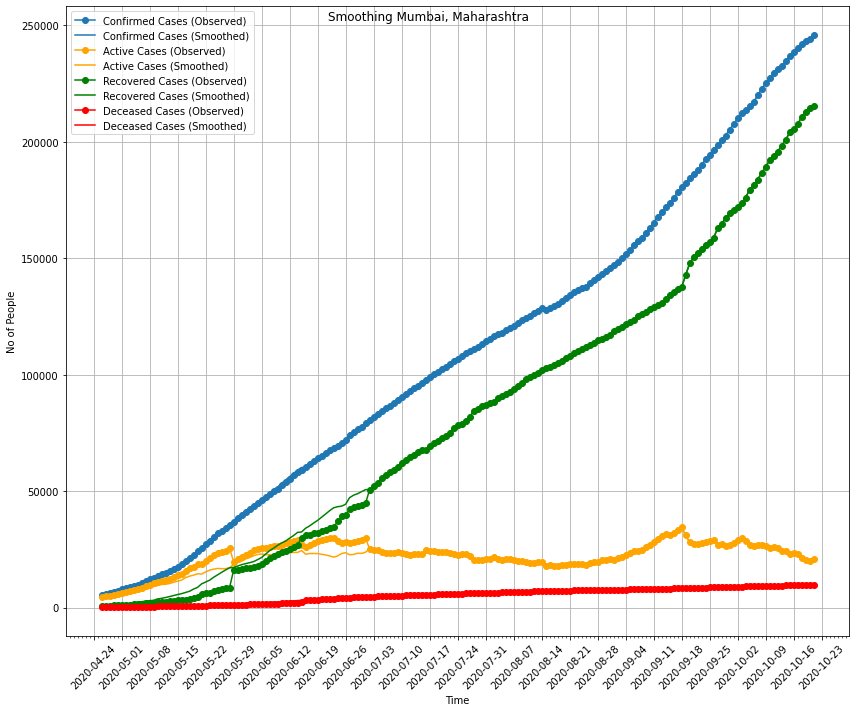

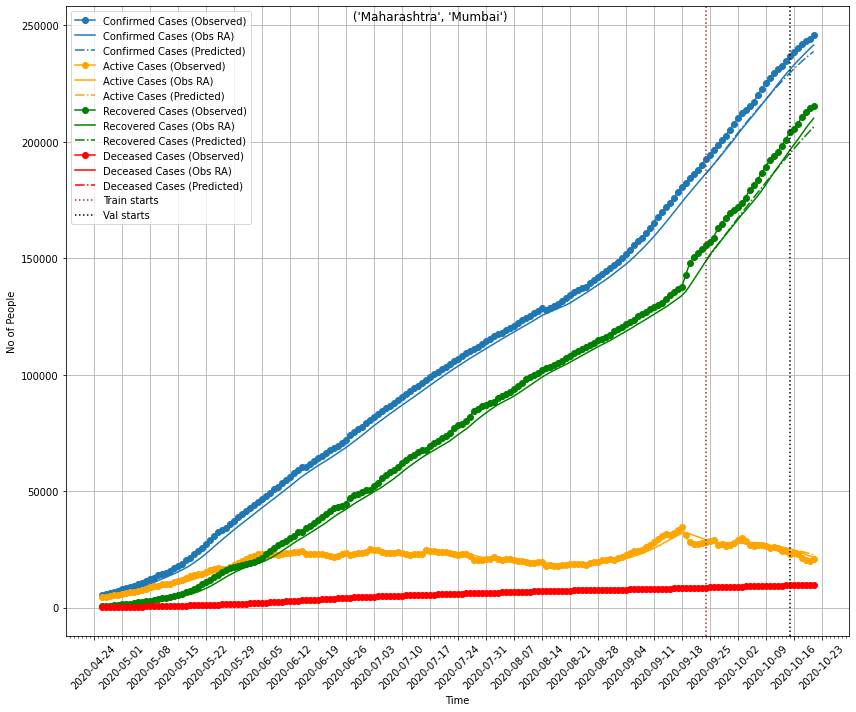

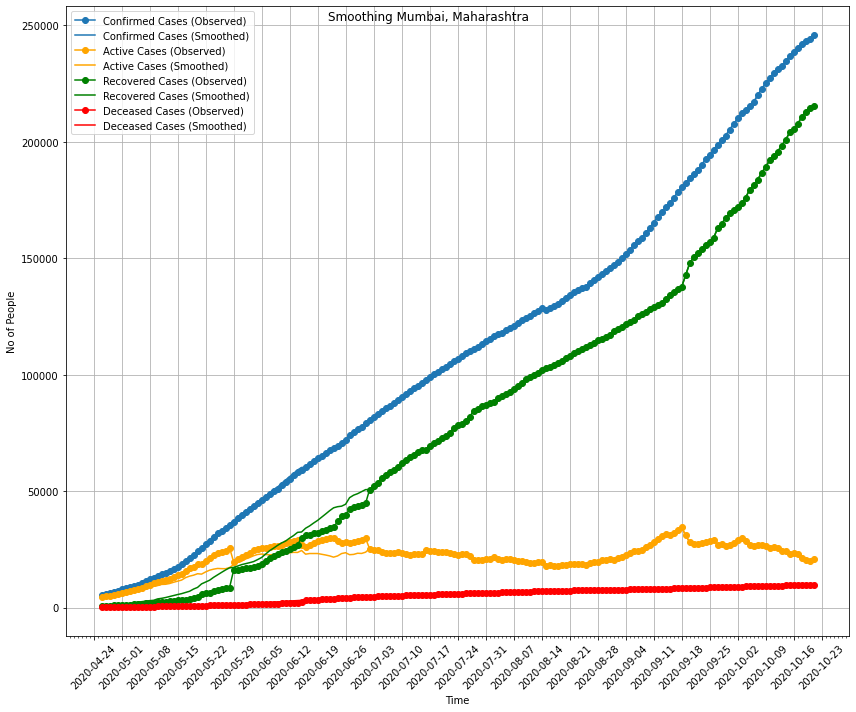

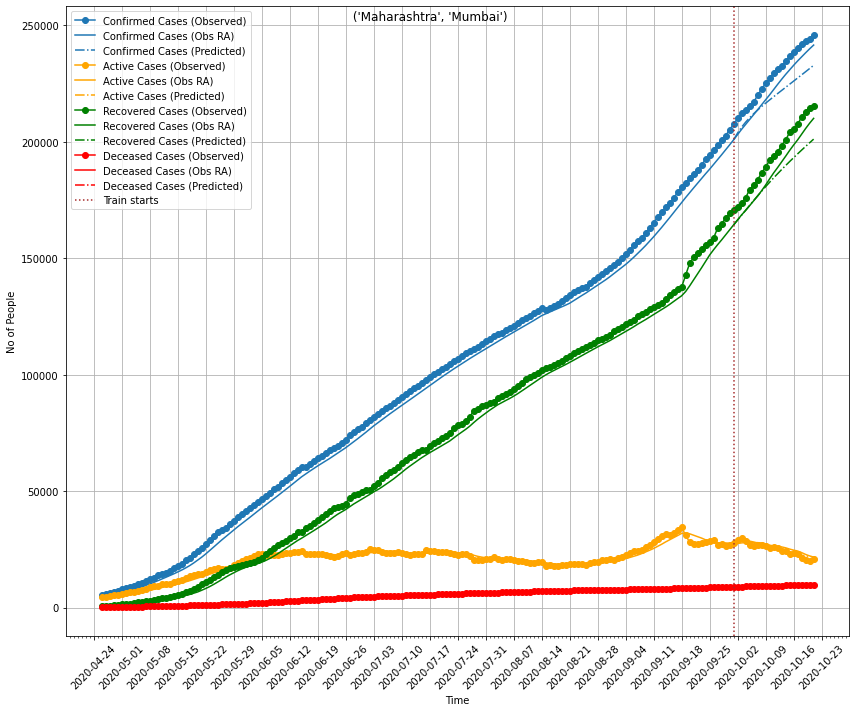

In [154]:
predictions_dict['m1'] = single_fitting_cycle(**copy.deepcopy(config['fitting'])) 

m2_params = copy.deepcopy(config['fitting'])
m2_params['split']['val_period'] = 0
predictions_dict['m2'] = single_fitting_cycle(**m2_params)

predictions_dict['fitting_date'] = datetime.datetime.now().strftime("%Y-%m-%d")

In [155]:
predictions_dict['m1']['best_params']

{'E_hosp_ratio': 2.4371377081429486,
 'I_D_hosp_ratio': 0.3354130235279869,
 'I_U_hosp_ratio': 2.4220495389421215,
 'P_fatal': 0.03751953891494196,
 'T_inc': 4.228464554528305,
 'T_inf_D': 5.625426825254461,
 'T_inf_U': 5.1191050372190015,
 'T_recov_fatal': 36.685482327617294,
 'T_recov_severe': 11.653033029377863,
 'beta': 0.12897322418822743,
 'd': 0.17592351720652194}

In [156]:
predictions_dict['m2']['best_params']

{'E_hosp_ratio': 2.190549692744775,
 'I_D_hosp_ratio': 0.37464377391514087,
 'I_U_hosp_ratio': 2.521618132675789,
 'P_fatal': 0.04942299568755757,
 'T_inc': 4.608491268520652,
 'T_inf_D': 3.196214859347779,
 'T_inf_U': 5.953901391299393,
 'T_recov_fatal': 31.300346074829847,
 'T_recov_severe': 12.944741494789676,
 'beta': 0.17952167951093784,
 'd': 0.0008083701297294601}

## Loss Dataframes

### M1 Loss DataFrame

In [157]:
predictions_dict['m1']['df_loss']

,train,val
total,2.95863,2.99414
active,2.66897,11.0085
recovered,3.54476,4.4478
deceased,2.38591,2.32569


### M2 Loss DataFrame

In [158]:
predictions_dict['m2']['df_loss']

,train
total,4.07004
active,3.15698
recovered,4.93296
deceased,0.744757


## Sensitivity Plot

In [85]:
predictions_dict['m1']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m1')
# predictions_dict['m2']['plots']['sensitivity'], _, _ = calculate_sensitivity_and_plot(predictions_dict, config, which_fit='m2')

KeyboardInterrupt: 

## Plot Forecasts

getting forecasts ..
3it [00:00, 26.14it/s]getting forecasts ..
1000it [00:48, 20.83it/s]


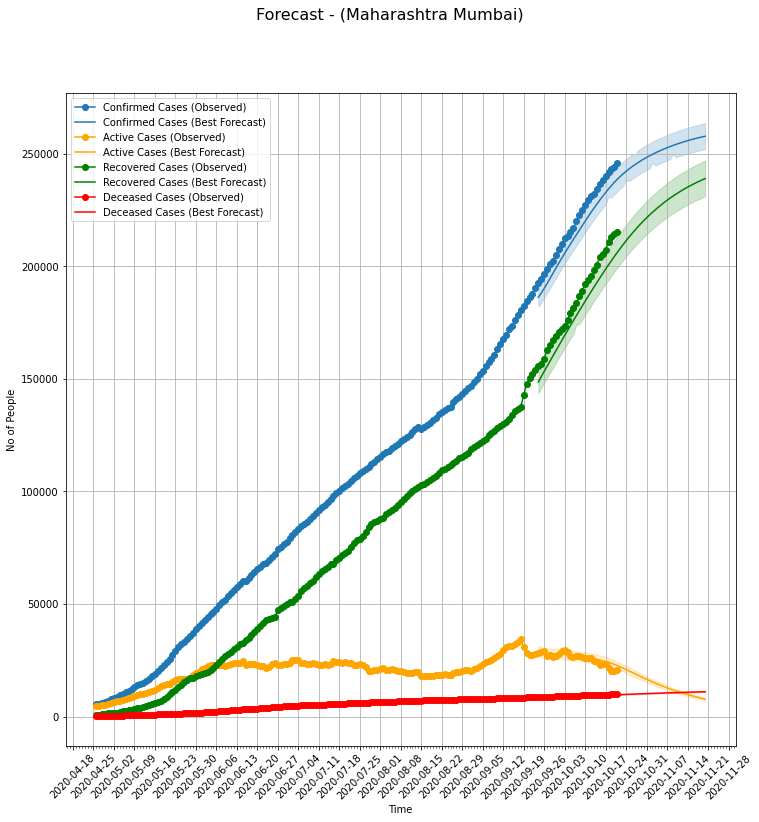

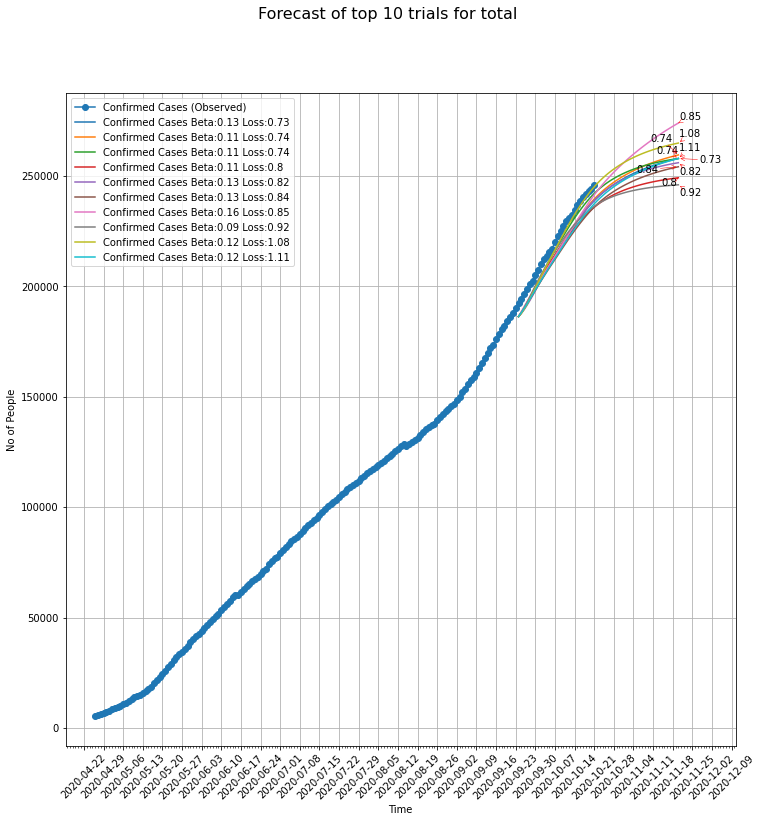

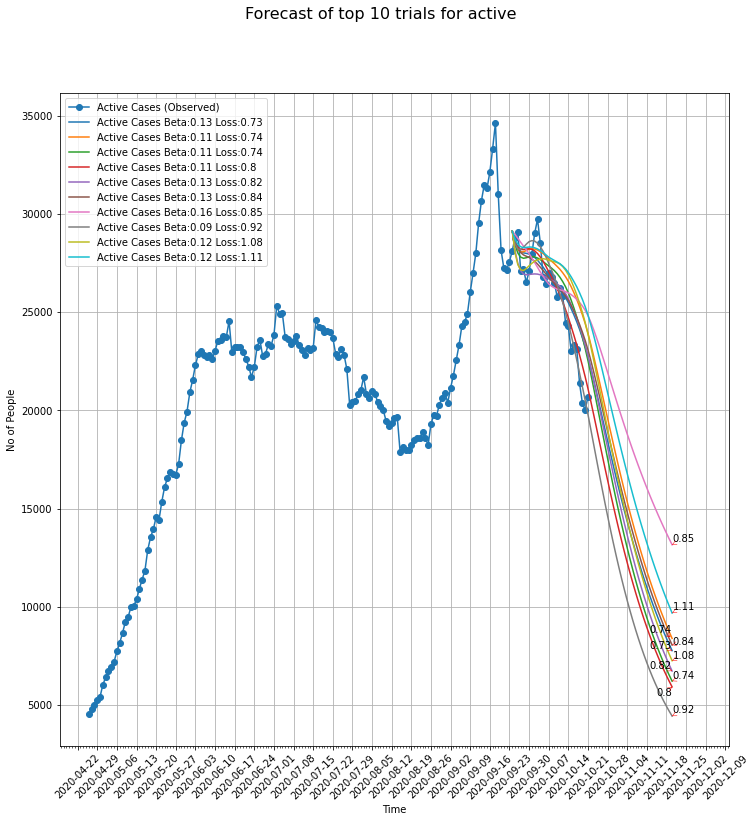

In [161]:
predictions_dict['m1']['forecasts'] = {}
predictions_dict['m1']['forecasts']['best'] = get_forecast(predictions_dict, train_fit='m1', 
                                                           model=config['fitting']['model'], 
                                                           days=config['forecast']['forecast_days'], tests_done=10000)

predictions_dict['m1']['plots']['forecast_best'] = plot_forecast(predictions_dict,
                                                                 (config['fitting']['data']['dataloading_params']['state'], 
                                                                  config['fitting']['data']['dataloading_params']['district']), 
                                                                 error_bars=True, train_fit='m1')

predictions_dict['m1']['trials_processed'] = forecast_all_trials(predictions_dict, train_fit='m1', 
                                                                 model=config['fitting']['model'], 
                                                                 forecast_days=config['forecast']['forecast_days'], tests_done=10000)

kforecasts = plot_top_k_trials(predictions_dict, train_fit='m1',
                               k=config['forecast']['num_trials_to_plot'],
                               which_compartments=config['forecast']['plot_topk_trials_for_columns'])
                               
predictions_dict['m1']['plots']['forecasts_topk'] = {}
for column in config['forecast']['plot_topk_trials_for_columns']:
    predictions_dict['m1']['plots']['forecasts_topk'][column.name] = kforecasts[column]

## Uncertainty + Uncertainty Forecasts

In [151]:
uncertainty_args = {'predictions_dict': predictions_dict, **config['uncertainty']['uncertainty_params']}
uncertainty = config['uncertainty']['method'](**uncertainty_args)

TypeError: __init__() missing 1 required positional argument: 'which_fit'

In [152]:
uncertainty.beta_loss

NameError: name 'uncertainty' is not defined

In [ ]:
uncertainty_forecasts = uncertainty.get_forecasts()
for key in uncertainty_forecasts.keys():
    predictions_dict['m2']['forecasts'][key] = uncertainty_forecasts[key]['df_prediction']

In [ ]:
predictions_dict['m2']['beta'] = uncertainty.beta
predictions_dict['m2']['beta_loss'] = uncertainty.beta_loss
predictions_dict['m2']['deciles'] = uncertainty_forecasts

In [ ]:
predictions_dict['m2']['plots']['forecast_best_50'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 50], error_bars=False)
predictions_dict['m2']['plots']['forecast_best_80'] = plot_forecast(predictions_dict, 
                                                                    (config['fitting']['data']['dataloading_params']['state'], 
                                                                     config['fitting']['data']['dataloading_params']['district']),
                                                                    fits_to_plot=['best', 80], error_bars=False)

In [ ]:
ptiles_plots = plot_ptiles(predictions_dict, which_compartments=config['forecast']['plot_ptiles_for_columns'])
predictions_dict['m2']['plots']['forecasts_ptiles'] = {}
for column in config['forecast']['plot_ptiles_for_columns']:
    predictions_dict['m2']['plots']['forecasts_ptiles'][column.name] = ptiles_plots[column]

## Create Report

In [162]:
save_dict_and_create_report_simple(predictions_dict, config, ROOT_DIR=output_folder, config_filename=config_filename)

KeyError: 'region'

## Create Output

In [163]:
df_output = create_decile_csv_new(predictions_dict)
df_output.to_csv(f'{output_folder}/deciles.csv')

KeyError: 'forecasts'

In [160]:
log_wandb(predictions_dict)

ValueError: You must call `wandb.init` in the same process before calling log

## Create All Trials Output

In [ ]:
df_all = create_all_trials_csv(predictions_dict)
df_all.to_csv(f'{output_folder}/all_trials.csv')